In [139]:
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import pandas as pd
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import random_split, DataLoader, Dataset
from torch import Ea
from collections import Counter

In [140]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(torch.cuda.get_device_name(device))
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)

else:
    device = torch.device("cpu")

print(device.type)

NVIDIA GeForce RTX 2070 Super
cuda


In [141]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

transform2 = transforms.Compose(
    [transforms.RandomHorizontalFlip(0.5),
     transforms.RandomVerticalFlip(0.5),
     transforms.RandomRotation(24),
     transforms.ToTensor(),
     transforms.RandomErasing(0.2),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

dataset = torchvision.datasets.ImageFolder("./train", transform=transform)
dataset1 = torchvision.datasets.ImageFolder("./train", transform=transform2)

# Image dimensions 3x64x64

total_size = len(dataset)
total_size1 = len(dataset1)
print(f"Size of total dataset: {total_size} images from {len(dataset.classes)} classes")
print(f"Size of total dataset: {total_size1} images from {len(dataset.classes)} classes")

train_percentage = 0.7
val_percentage = 0.15
test_percentage = 0.15

train_size = int(train_percentage * total_size)
val_size = int(val_percentage * total_size)
test_size = total_size - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

Size of total dataset: 88011 images from 50 classes
Size of total dataset: 88011 images from 50 classes


In [142]:
BATCH_SIZE = 32
TEST_BATCH_SIZE = 1024
train_data_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=16, pin_memory=True)
val_data_loader = DataLoader(val_dataset, batch_size=TEST_BATCH_SIZE, shuffle=False, num_workers=16)
test_data_loader = DataLoader(test_dataset, batch_size=TEST_BATCH_SIZE, shuffle=False, num_workers=16)

In [143]:
def predict_from_logits(logits, y_hat):
    pred_probabilites = nn.Softmax(dim=1)(logits)
    predictions = pred_probabilites.argmax(1)

    correct = (predictions == y_hat).sum().item()
    return predictions, correct

def predict_from_logits_train(logits, y_hat):
    predictions = logits.argmax(dim=1)
    correct = (predictions == y_hat).sum().item()
    return predictions, correct


In [242]:
class EarlyStopping:
    def __init__(self, tolerance=5, min_delta=0):

        self.tolerance = tolerance
        self.min_delta = min_delta
        self.counter = 0
        self.early_stop = False

    def __call__(self, train_loss, validation_loss):
        if (validation_loss - train_loss) > self.min_delta:
            self.counter +=1
            if self.counter >= self.tolerance:
                self.early_stop = True

In [243]:
def train(model: nn.Module, epochs: int, optimizer, scheduler, loss_module, early_stopping) -> np.ndarray:
    train_losses = []
    val_losses = []
    train_acc = []
    val_acc = []

    for epoch in range(epochs):
        total_train_loss = 0
        total_val_loss = 0

        train_correct = 0
        train_total = 0

        val_correct = 0
        val_total = 0

        model.train()
        for data_inputs, data_labels in train_data_loader:
            data_inputs, data_labels = data_inputs.to(device), data_labels.to(device)

            logits = model(data_inputs)
            loss = loss_module(logits, data_labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()

            _, correct = predict_from_logits_train(logits, data_labels)

            train_correct += correct
            train_total += data_labels.size(0)

        train_accuracy = 100 * train_correct / train_total
        avg_train_loss = total_train_loss / len(train_data_loader)
        train_losses.append(avg_train_loss)
        train_acc.append(train_accuracy)


        model.eval()
        with torch.no_grad():
            for data_inputs, data_labels in val_data_loader:
                data_inputs, data_labels = data_inputs.to(device), data_labels.to(device)

                logits = model(data_inputs)


                loss = loss_module(logits, data_labels)
                total_val_loss += loss.item()

                _, correct = predict_from_logits_train(logits, data_labels)

                val_correct += correct
                val_total += data_labels.size(0)

        val_accuracy = 100 * val_correct / val_total
        avg_val_loss = total_val_loss / len(val_data_loader)
        val_losses.append(avg_val_loss)
        val_acc.append(val_accuracy)

        scheduler.step()
        print(f"Epoch {epoch+1}| Train Loss = {avg_train_loss:.4f} Train acc = {train_accuracy:.4f}| Val Loss = {avg_val_loss:.4f}| Val acc = {val_accuracy:.4f}")

        early_stopping(avg_train_loss, avg_val_loss)
        if early_stopping.early_stop:
          print("Early stopping! We are at epoch:", epoch)
          break

    history = [train_losses, train_acc, val_losses, val_acc]
    return np.array(history)

In [234]:
class ImagesClassifier(nn.Module):
    def __init__(self, num_outputs):
        super().__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=1, padding=3),  # 64x64 → 64x64
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 32x32

            nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=2),  # 32x32 → 32x32
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 16x16

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=0),  # 16x16 → 14x14
            nn.BatchNorm2d(256),
            nn.ReLU(),

            nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=0),  # 14x14 → 12x12
            nn.BatchNorm2d(384),
            nn.ReLU(),

            nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),  # 12x12 → 12x12
            nn.BatchNorm2d(256),
            nn.ReLU(),

            nn.MaxPool2d(kernel_size=3, stride=2) #5x5,
        )



        self.flatten = nn.Flatten()

        self.classifier = nn.Sequential(
            nn.Linear(256 * 5 * 5, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.5),

            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.5),

            nn.Linear(256, num_outputs)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.flatten(x)
        x = self.classifier(x)
        return x

In [235]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [236]:
model = ImagesClassifier(num_outputs=50)
model.to(device)

ImagesClassifier(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1))
    (12): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU()
    (14): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): B

In [237]:
count_parameters(model)

5704882

In [238]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
#, weight_decay=0.0001


loss_module = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)
early_stopping = EarlyStopping(tolerance=5, min_delta=10)

In [239]:
history = train(model, epochs=20, optimizer=optimizer, scheduler=scheduler, loss_module=loss_module, early_stopping=early_stopping)

Epoch 1| Train Loss = 3.1551 Train acc = 16.8650| Val Loss = 2.6209| Val acc = 29.0762
Epoch 2| Train Loss = 2.6436 Train acc = 28.6802| Val Loss = 2.3389| Val acc = 35.9391
Epoch 3| Train Loss = 2.3964 Train acc = 34.9084| Val Loss = 2.1178| Val acc = 41.8589
Epoch 4| Train Loss = 2.2066 Train acc = 40.0945| Val Loss = 1.9434| Val acc = 45.8016
Epoch 5| Train Loss = 2.0530 Train acc = 43.7191| Val Loss = 1.8479| Val acc = 48.5286
Epoch 6| Train Loss = 1.9102 Train acc = 47.4930| Val Loss = 1.7519| Val acc = 51.0965
Epoch 7| Train Loss = 1.7918 Train acc = 50.4375| Val Loss = 1.6844| Val acc = 53.7098
Epoch 8| Train Loss = 1.6730 Train acc = 53.4404| Val Loss = 1.6096| Val acc = 55.4255
Epoch 9| Train Loss = 1.5556 Train acc = 56.5488| Val Loss = 1.5478| Val acc = 57.3798
Epoch 10| Train Loss = 1.4386 Train acc = 59.3374| Val Loss = 1.5556| Val acc = 57.1980
Epoch 11| Train Loss = 1.3240 Train acc = 62.4507| Val Loss = 1.5408| Val acc = 57.9139
Epoch 12| Train Loss = 1.2208 Train acc =

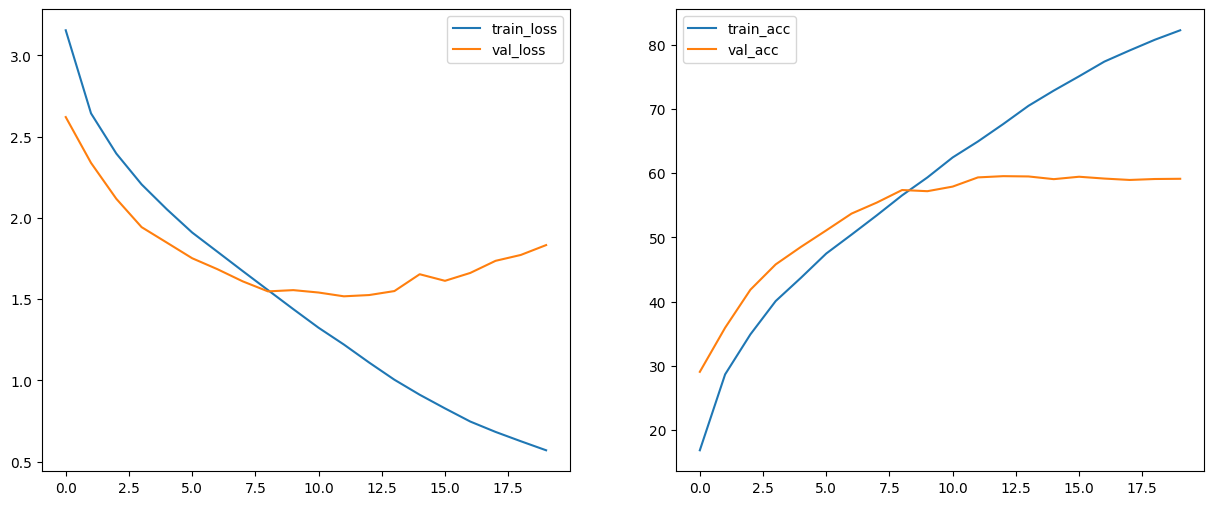

In [240]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,6))
ax1.plot(history[0, :], label="train_loss")
ax1.plot(history[2, :], label="val_loss")
ax1.legend()

ax2.plot(history[1, :], label="train_acc")
ax2.plot(history[3, :], label="val_acc")
ax2.legend()

# Evaluation

In [241]:
model.eval()
true_preds, num_preds = 0., 0.

test_y_hat = []
test_y = []
with torch.no_grad():
    for data_inputs, data_labels in test_data_loader:
        data_inputs, data_labels = data_inputs.to(device), data_labels.to(device)


        logits = model(data_inputs)
        predictions, correct = predict_from_logits(logits, data_labels)


        test_y_hat.append(predictions.to("cpu").numpy())
        test_y.append(data_labels.to("cpu").numpy())

        true_preds += correct
        num_preds += data_labels.shape[0]

test_accuracy = (true_preds / num_preds) * 100.0
print(f"Accuracy of the model: {test_accuracy:.2f}%")

Accuracy of the model: 58.37%
